In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True) 
    tf.config.set_visible_devices([gpus[0]], "GPU")

print(gpus)
import tensorflow as tf
print(tf.__version__)

print("current device：", tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.2
当前设备： /device:GPU:0


In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

import os,PIL
import numpy as np
np.random.seed(1)
tf.random.set_seed(1)
import pathlib

In [3]:

data_dir = "D:\\cvLearning\\clustering\\data3_a"


data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("The total number of images is：", image_count)

图片总数为： 5492


In [5]:
batch_size = 64
img_height = 128
img_width = 128

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 12,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5492 files belonging to 6 classes.
Using 4394 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 12,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 5492 files belonging to 6 classes.
Using 1098 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['B_a', 'C_a', 'D_a', 'Denvour_a', 'Grant_a', 'yongsong_a']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [10]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),  # Add a convolutional layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [11]:
# Set dynamic learning rate

initial_learning_rate = 2e-3

# Exponential Decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 20,  # Not epochs
    decay_rate = 0.99,  # After each decay, the learning rate becomes decay_rate * lr
    staircase = True
)

optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [12]:
model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [13]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/50
69/69 [==============================] - 15s 72ms/step - loss: 15.3925 - accuracy: 0.3778 - val_loss: 2.0733 - val_accuracy: 0.5756
Epoch 2/50
69/69 [==============================] - 4s 52ms/step - loss: 1.9184 - accuracy: 0.5517 - val_loss: 1.6564 - val_accuracy: 0.6348
Epoch 3/50
69/69 [==============================] - 4s 53ms/step - loss: 1.6167 - accuracy: 0.6461 - val_loss: 1.5047 - val_accuracy: 0.6913
Epoch 4/50
69/69 [==============================] - 4s 52ms/step - loss: 1.4865 - accuracy: 0.6775 - val_loss: 1.3512 - val_accuracy: 0.7158
Epoch 5/50
69/69 [==============================] - 4s 54ms/step - loss: 1.3114 - accuracy: 0.7424 - val_loss: 1.2929 - val_accuracy: 0.7614
Epoch 6/50
69/69 [==============================] - 4s 52ms/step - loss: 1.1884 - accuracy: 0.7838 - val_loss: 1.1355 - val_accuracy: 0.8033
Epoch 7/50
69/69 [==============================] - 4s 52ms/step - loss: 1.1171 - accuracy: 0.8116 - val_loss: 1.0593 - val_accuracy: 0.8279
Epoch 8/50


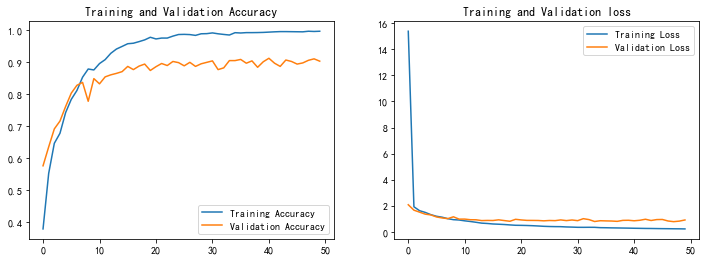

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Define a function to plot the confusion matrix
def plot_cm(labels, predictions):
    
    # Generate the confusion matrix
    conf_numpy = confusion_matrix(labels, predictions)
    # Convert the matrix to a DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_df, annot=True, annot_kws={"fontsize":12}, cmap="BuPu")
    
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True Value', fontsize=14)
    plt.xlabel('Predicted Value', fontsize=14)

In [16]:
val_pre = []
val_label = []

for images, labels in val_ds:  # You can take a subset of validation data (.take(1)) to generate the confusion matrix
# for images, labels in val_ds.take(1):  # You can take a subset of validation data (.take(1)) to generate the confusion matrix
    for image, label in zip(images, labels):
        # Need to add one dimension to the image
        img_array = tf.expand_dims(image, 0)
        # Use the model to predict the person in the image
        prediction = model.predict(img_array)
        
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])


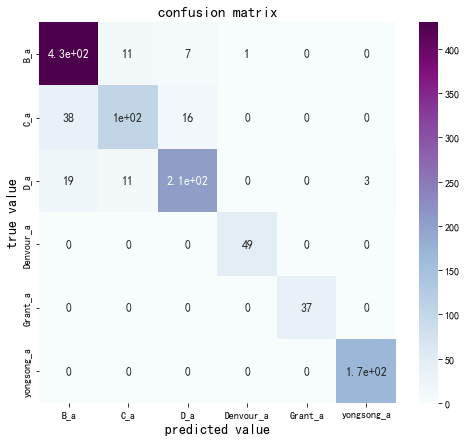

In [17]:
plot_cm(val_label, val_pre)

In [18]:
model.save('model/style_small_4conv_newdataset.h5')

In [19]:
new_model = tf.keras.models.load_model('model/style_small_4conv_newdataset.h5')

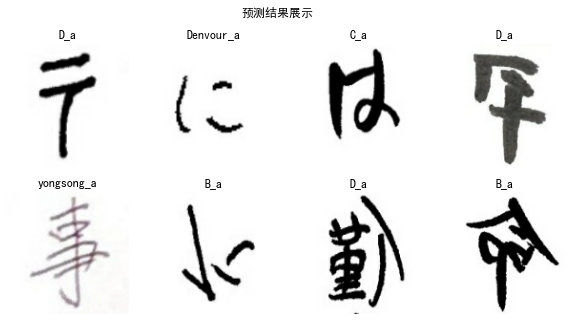

In [20]:
plt.figure(figsize = (10, 5))
plt.suptitle("Forecast Result Display")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        img_array = tf.expand_dims(images[i], 0)
        
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])
        
        plt.axis("off")